In [82]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import Config
import datetime
import time
import copy
import BS

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score

from pymongo import MongoClient
client=MongoClient(Config.DB_Hostname,Config.DB_Port)

def _calc_spread_return(spot, long_start, long_end, short_start, short_end, strike_spread):
    
    spread_benefit = short_start - long_start
    margin = spot*0.02 - spread_benefit
    brokerage = (long_start + long_end + short_start + short_end) * 0.001
    
    if spread_benefit > 0:
        margin += strike_spread
        
    if margin <0:
        print(f"Error_{margin}")
    
    return (long_end - long_start + short_start - short_end - brokerage)/margin


class Gap_Move_Classifier:
    
    def __init__(self, start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period):
        
        self.start_date = start_date #2017-01-01
        self.end_date = end_date #2017-01-01
        self.prediction_date = prediction_date #2017-01-01
        self.underlying = underlying #NIFTY, BANKNIFTY
        self.underlying_dynamics = None
        self.vol_surface = None
        self.days_to_expiry = None
        self.data_matrix = None
        self.return_matrix = None
        self.price_matrix = None
        self.performance_stats = None
        self.start_holding_period = start_holding_period #in minutes
        self.end_holding_period = end_holding_period #in minutes
        self.strike_range = [-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
        
        #start = time.time()
        self.underlying_dynamics = pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}OHLC'].find())
        self.underlying_dynamics.drop(columns=['_id'],inplace=True)
        self.underlying_dynamics.sort_values(['date','batch_id'],inplace=True)
        self.underlying_dynamics=self.underlying_dynamics[(self.underlying_dynamics.date>=self.start_date)&(self.underlying_dynamics.date<=self.end_date)]
        self.underlying_dynamics.batch_id=self.underlying_dynamics.batch_id.astype(int)
        self.underlying_dynamics.set_index('date',inplace=True)
        #print(f"Prices Downloaded in {time.time() - start} seconds")

        #start=time.time()
        self.vol_surface=pd.DataFrame(client[f'{Config.Data_DB}']['Vol_Surface'].find({"SYMBOL" : self.underlying}))
        self.vol_surface.drop(columns=['_id', 'CONTRACTS', 'VAL_INLAKH','OPEN_INT', 'CHG_IN_OI', 'SYMBOL'], inplace=True)
        self.vol_surface.sort_values('date',inplace=True)
        self.vol_surface=self.vol_surface[(self.vol_surface.date>=self.start_date)&(self.vol_surface.date<=self.end_date)]
        self.vol_surface.set_index('date',inplace=True)
        #print(f"Vol Surface Downloaded in {time.time() - start} seconds")
        
        #start=time.time()
        self.days_to_expiry = pd.DataFrame(client[f'{Config.Data_DB}']['Days_To_Expiry'].find({"underlying":self.underlying}))
        self.days_to_expiry.drop(columns = ['_id','underlying'],inplace=True)
        self.days_to_expiry.sort_values('date',inplace=True)
        self.days_to_expiry=self.days_to_expiry[(self.days_to_expiry.date>=self.start_date)&(self.days_to_expiry.date<=self.end_date)]
        self.days_to_expiry.set_index('date',inplace=True)
        #print(f"Expiry Dates Downloaded in {time.time()-start} seconds")

        #start=time.time()
        self._make_features()
        #print(f"Features Engineered in {time.time() - start} seconds")

        #start=time.time()
        self._generate_return_matrix()
        #print(f"Features Engineered in {time.time() - start} seconds")
                
    def _make_features(self):
        
        vol_surface = copy.deepcopy(self.vol_surface)
        if self.end_date not in vol_surface.index:
            vol_surface.loc[self.end_date] = [np.nan]*len(vol_surface.columns)

        closing_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==375 - (self.start_holding_period - 1)][['open']]
        if self.end_date not in closing_candle.index:
            closing_candle.loc[self.end_date] = np.nan
        closing_candle=closing_candle.shift()
        
        opening_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==1 + (self.end_holding_period - 1)][['close']]
        if self.end_date not in opening_candle.index:
            opening_candle.loc[self.end_date] = np.nan
        
        candle = pd.merge(closing_candle, opening_candle, left_index=True, right_index=True)
        candle.close = np.where(candle.close.isna(), candle.open, candle.close)
        
        self.data_matrix = pd.DataFrame()
        self.data_matrix["gap_move"] = (candle.close - candle.open) / candle.open
        self.data_matrix["gap_move_flag"] = np.where(self.data_matrix.gap_move>=0, 1, 0)
        self.data_matrix = pd.merge(self.data_matrix, vol_surface.shift(), left_index = True, right_index = True).dropna()
        
        candle = pd.merge(candle, self.days_to_expiry, left_index=True, right_index=True)
        candle = pd.merge(candle , 
                          self.days_to_expiry.shift().rename(columns = 
                            {"current_week" : "current_week_yesterday", "next_week": "next_week_yesterday"}), 
                          left_index=True,
                          right_index=True)
        
        candle.current_week_yesterday = np.where(candle.current_week_yesterday == 1, candle.next_week_yesterday, candle.current_week_yesterday)
        candle["IVOL"] = vol_surface["vol_0"].shift()
        candle.dropna(inplace = True)
        
        for strike_range in self.strike_range:
            
            candle[f"{strike_range}_strike_call_and_put"] = candle.open * (1 + strike_range/100) * np.exp(Config.interest_rate * (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365)
            
            candle[f"call_{strike_range}_yesterday"] = candle.apply(lambda x : (BS.bs_call(x.open, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week_yesterday - 1 + self.start_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
            
            candle[f"call_{strike_range}_today"] = candle.apply(lambda x : (BS.bs_call(x.close, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week - 0.75 - self.end_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)

            candle[f"put_{strike_range}_yesterday"] = candle.apply(lambda x : (BS.bs_put(x.open, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week_yesterday - 1 + self.start_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
            
            candle[f"put_{strike_range}_today"] = candle.apply(lambda x : (BS.bs_put(x.close, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week - 0.75 - self.end_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
                
        self.price_matrix = candle[(candle.columns[candle.columns.str.contains('call')])| (candle.columns[candle.columns.str.contains('put')]) ]
        self.price_matrix["open"] = candle[['open']]
        self.price_matrix["current_week_yesterday"] = candle[['current_week_yesterday']]
        
    def _generate_return_matrix(self):
        
        self.return_matrix = pd.DataFrame({"date":sorted(self.price_matrix.index)}).set_index('date')
        for index, strike_range_lower in enumerate(self.strike_range[:-1]):
            for strike_range_upper in self.strike_range[index+1:]:

                call_long_yesterday = f"call_{strike_range_lower}_yesterday"
                call_long_today = f"call_{strike_range_lower}_today"
                call_short_yesterday = f"call_{strike_range_upper}_yesterday"
                call_short_today = f"call_{strike_range_upper}_today"
                call_short_strike = f"{strike_range_upper}_strike_call_and_put"
                call_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                put_long_yesterday = f"put_{strike_range_lower}_yesterday"
                put_long_today = f"put_{strike_range_lower}_today"
                put_short_yesterday = f"put_{strike_range_upper}_yesterday"
                put_short_today = f"put_{strike_range_upper}_today"
                put_short_strike = f"{strike_range_upper}_strike_call_and_put"
                put_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                if strike_range_lower<=0.75:
                    self.return_matrix[f"call_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'],
                                                                                        x[call_long_yesterday], 
                                                                                        x[call_long_today], 
                                                                                        x[call_short_yesterday],
                                                                                        x[call_short_today], 
                                                                                        x[call_short_strike] - x[call_long_strike]),
                                                                                        axis=1)
                if strike_range_lower>=-0.75:
                    self.return_matrix[f"put_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'], 
                                                                                         x[put_long_yesterday], 
                                                                                         x[put_long_today],
                                                                                         x[put_short_yesterday],
                                                                                         x[put_short_today],  
                                                                                         x[put_short_strike] - x[put_long_strike]),
                                                                                         axis=1)
        
    def _generate_performance_stats(self, 
                                    tail = None, 
                                    return_matrix_user = None, 
                                    start_holding_period = None, 
                                    end_holding_period = None):
        
        if start_holding_period is not None:
            self.start_holding_period = start_holding_period
        
        if end_holding_period is not None:
            self.end_holding_period = end_holding_period
            
        if return_matrix_user is not None:
            self.return_matrix = return_matrix_user[return_matrix_user.columns[(return_matrix_user.columns.str.contains('call')) | (return_matrix_user.columns.str.contains('put'))]]

        sim = pd.DataFrame(index = self.return_matrix.columns)
        
        if tail is not None:
            self.return_matrix = self.return_matrix.tail(tail)        
        return_matrix = self.return_matrix.copy()
        
        sim["Sharpe"] = 16 * return_matrix.mean()/return_matrix.std()

        rolling_cumulative = (1 + return_matrix).rolling(60).apply(lambda x : x.prod()).dropna()
        sim["60_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["60_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["60_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["60_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        rolling_cumulative = (1 + return_matrix).rolling(250).apply(lambda x : x.prod()).dropna()
        sim["250_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["250_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["250_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["250_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        sim["Return"] = ((1 + return_matrix).cumprod().tail(1) ** (1/len(return_matrix)) - 1).mean()

        sim["Last_60_Day_Cumulative_Return"] = (1 + return_matrix).tail(60).cumprod().tail(1).mean()
        sim["Last_250_Day_Cumulative_Return"] = (1 + return_matrix).tail(250).cumprod().tail(1).mean()
        sim["MDD"] = (((1 + return_matrix).cumprod() / ((1 + return_matrix).cumprod().cummax())) - 1).min()   
        
        sim["start_holding_period"] = self.start_holding_period
        sim["end_holding_period"] = self.end_holding_period
        
        self.performance_stats = sim.copy()

In [92]:
start_date = '2015-01-09' #starting data point best left untouchedd
end_date = '2024-02-15'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
prediction_date = '2024-01-23' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
underlying = 'NIFTY' #NIFTY/BANKNIFTY
start_holding_period = 15
end_holding_period = 15
self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period)
self._generate_performance_stats()

In [2]:
start_holding_period = list(range(1,16))
end_holding_period = list(range(1,16))
tail = None
return_summary = []
summary = []
for start in start_holding_period:
    for end in end_holding_period:
        
        print(start,end)
        
        start_date = '2015-01-09' #starting data point best left untouchedd
        end_date = '2024-02-15'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
        prediction_date = '2024-01-19' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
        underlying = 'NIFTY' #NIFTY/BANKNIFTY
        self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start, end)
        self._generate_performance_stats(tail=tail)
        summary.append(self.performance_stats)
        
        temp = pd.merge(self.return_matrix, self.days_to_expiry[['current_week']], left_index = True, right_index = True)
        temp["start_holding_period"] = start
        temp["end_holding_period"] = end
        return_summary.append(temp)
        
summary = pd.concat(summary)
return_summary = pd.concat(return_summary)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
12 15
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
13 15
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
14 15
1

In [3]:
return_summary.current_week = np.where(return_summary.current_week == 5, 4, return_summary.current_week)
return_summary.current_week = np.where(return_summary.current_week == 6, 7, return_summary.current_week)
selected_strategies = []
for current_week in sorted(return_summary.current_week.unique()):
    
    print(current_week)
    temp = []
    for start in sorted(return_summary.start_holding_period.unique()):
        for end in sorted(return_summary.end_holding_period.unique()):
            
            self._generate_performance_stats(return_matrix_user = return_summary[(return_summary.current_week == current_week) & (return_summary.start_holding_period == start) & (return_summary.end_holding_period == end)], 
                                   start_holding_period = start, end_holding_period = end)
            temp.append(self.performance_stats)
    
    temp = pd.concat(temp)
    temp["current_week"] = current_week
    selected_strategies.append(temp.sort_values('Return', ascending=False).head(1))
selected_strategies = pd.concat(selected_strategies)
selected_strategies

1
2
3
4
7


,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period,current_week
call_-1.25_0.25,5.47803,6.01709,6.93962,20.41604,1.46749,1244.27399,1393.10483,5107.51871,259.76583,0.02915,1.75328,303.81450,-0.58598,1,9,1
call_-1.5_0.5,4.78137,4.36041,4.91537,22.18063,0.51087,939.63439,1033.71976,3313.76974,74.36704,0.02123,1.28623,434.92754,-0.57368,13,15,2
call_-1.5_0.75,6.18078,4.70031,9.86050,65.67081,0.52453,1528.58525,1601.20922,9091.15932,57.05739,0.02728,4.84609,9091.15932,-0.64038,13,13,3
call_-1.5_-0.25,3.93669,2.61252,2.58859,5.51697,0.64792,37.47567,53.13343,156.07138,18.08345,0.01321,3.40977,22.09187,-0.50836,1,1,4
call_-1.5_1.25,2.04195,1.26820,1.44544,3.59155,0.49453,3.60213,3.74360,7.92677,1.81397,0.00691,1.72577,3.78180,-0.63921,13,13,7


In [43]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(selected_strategies.index, 
                                              selected_strategies.start_holding_period, 
                                              selected_strategies.end_holding_period, 
                                              selected_strategies.current_week):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,4.49852,3.44016,4.20634,19.65796,0.26769,122.31642,615.06142,8680.88294,6.51851,0.01973,5.95295,86.41361,-0.87153,15,15


In [44]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2016-01-18                1.01455
            strategy_call_and_put
date                             
2017-01-23                1.01713
            strategy_call_and_put
date                             
2018-01-25                1.02888
            strategy_call_and_put
date                             
2019-02-01                1.01412
            strategy_call_and_put
date                             
2020-02-10                1.02211
            strategy_call_and_put
date                             
2021-02-11                1.02672
            strategy_call_and_put
date                             
2022-02-17                1.02592
            strategy_call_and_put
date                             
2023-02-21                1.00998
            strategy_call_and_put
date                             
2024-02-15                1.01800


In [54]:
temp = return_summary.drop(columns = ["current_week", "start_holding_period", "end_holding_period"]).max(axis=1).groupby('date').max()

In [69]:
(1+temp).expanding().apply(lambda x : x.prod()**(1/len(x))).describe()

count   2242.00000
mean       1.08014
std        0.00648
min        1.06571
25%        1.07747
50%        1.07902
75%        1.08126
max        1.19766
dtype: float64

In [48]:
selected_return_matrix.describe()

,strategy_call_and_put
count,2242.00000
mean,0.02335
std,0.08303
min,-0.38879
25%,-0.01827
50%,0.03486
75%,0.07871
max,0.24721


<Axes: xlabel='date'>

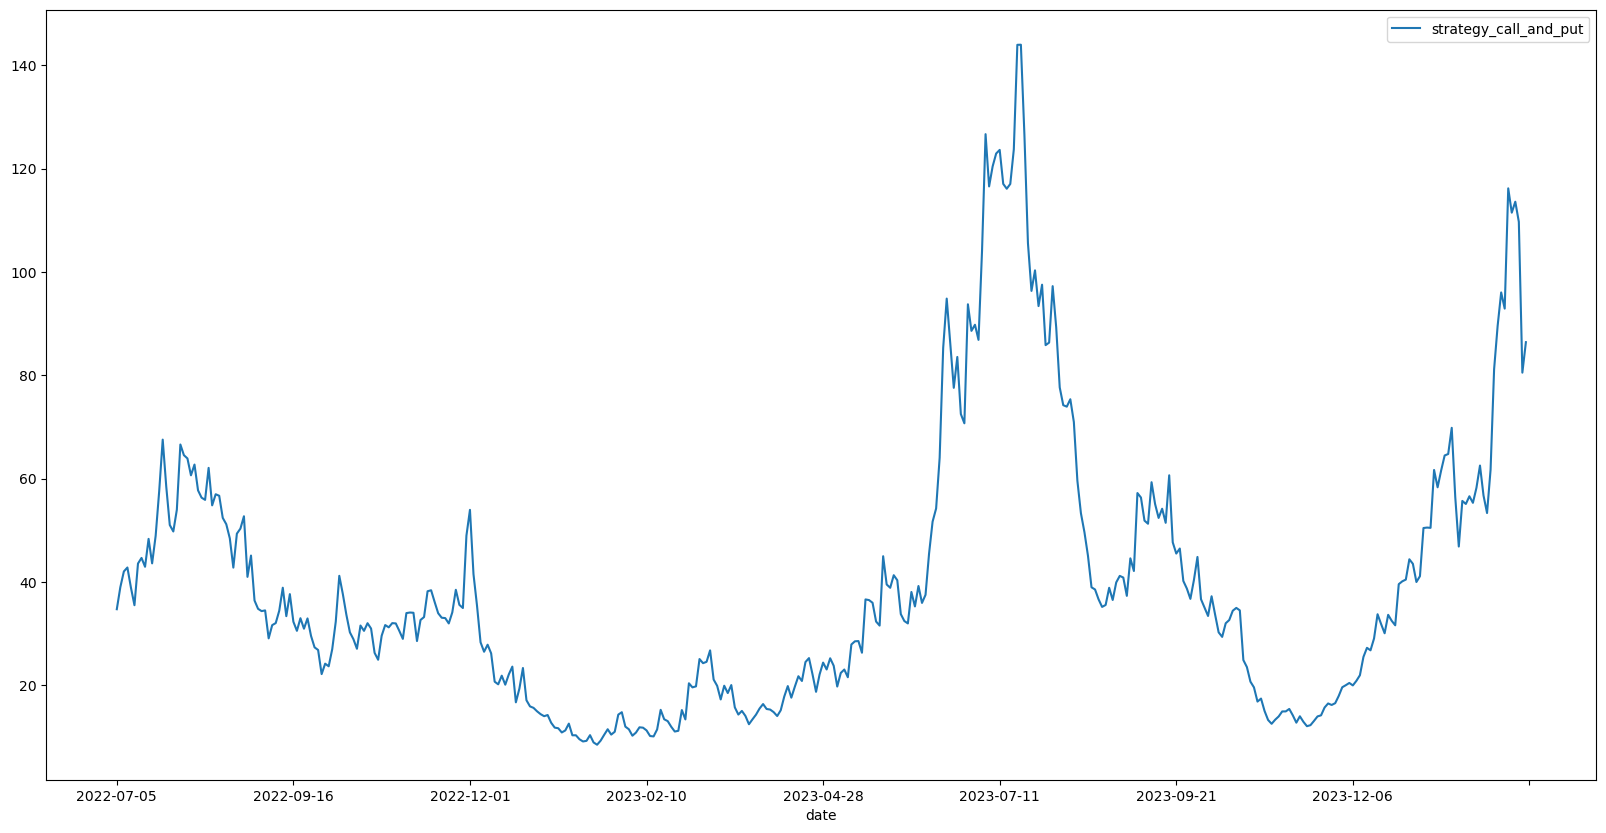

In [7]:
(1+selected_return_matrix).rolling(250).apply(lambda x: x.prod()).tail(400).plot(figsize=(20,10))

In [25]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(['call_-1.25_0', 'call_-1.5_0.25', 'call_-1.5_0.75', 'call_-1.5_-0.25',
       'call_-1.5_1.5'], [1, 9, 9, 9, 9], [1, 13, 1, 1, 10], [1, 2, 3, 4, 7]):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,4.35082,3.02730,3.51918,13.47995,0.27960,76.41690,206.38885,2163.42070,5.17653,0.01773,6.24310,156.05941,-0.86823,15,15


In [26]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2228]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2016-01-18                1.01382
            strategy_call_and_put
date                             
2017-01-23                1.01388
            strategy_call_and_put
date                             
2018-01-25                1.02659
            strategy_call_and_put
date                             
2019-02-01                1.01138
            strategy_call_and_put
date                             
2020-02-10                1.01802
            strategy_call_and_put
date                             
2021-02-11                1.02275
            strategy_call_and_put
date                             
2022-02-17                1.02011
            strategy_call_and_put
date                             
2023-02-21                1.01234
            strategy_call_and_put
date                             
2024-01-25                1.01912


In [10]:
selected_return_matrix.describe()

,strategy_call_and_put
count,2242.00000
mean,0.02070
std,0.07665
min,-0.40153
25%,-0.01399
50%,0.03441
75%,0.07092
max,0.27585


In [11]:
temp = summary.copy()
for metric in ['Sharpe', 'MDD', '250_Day_Median_Cumulative_Return', '60_Day_Median_Cumulative_Return',
               'Return', 'Last_250_Day_Cumulative_Return', 'Last_60_Day_Cumulative_Return']:
    temp = temp[temp[metric]>=temp[metric].quantile(0.7)]
    
temp

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_-0.75_-0.25,4.41223,1.75928,1.77061,3.17383,0.59536,9.42558,10.92485,30.56792,2.44015,0.00895,2.34681,11.70996,-0.55369,9,4
put_-0.75_-0.25,4.45698,1.75771,1.78495,3.25643,0.59962,9.48232,11.25273,32.29195,2.61986,0.00905,2.33758,11.74885,-0.55458,9,5
put_-0.75_-0.25,4.23332,1.73255,1.75277,3.50540,0.55597,8.47737,10.28908,30.73447,2.37224,0.00874,2.41482,10.22955,-0.56068,9,6
put_-0.75_-0.25,4.28503,1.72918,1.76624,3.47333,0.56433,8.58293,10.85482,33.93828,2.66203,0.00882,2.36935,9.60046,-0.55375,9,7
put_-0.75_-0.25,4.34240,1.74458,1.78046,3.45773,0.53416,8.97372,11.30309,34.83379,2.66210,0.00893,2.33139,9.73949,-0.56335,9,8
put_-0.75_-0.25,4.45554,1.77809,1.80267,3.44752,0.54901,9.58819,11.80560,34.78099,2.85387,0.00914,2.34854,10.29211,-0.56891,9,9


In [12]:
summary.sort_values("Sharpe", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,4.69132,2.57645,2.72901,9.58700,0.25900,35.83913,71.17379,604.72196,4.18530,0.01463,3.69191,34.37248,-0.82839,1,10
call_-1.5_-0.25,4.67795,2.55971,2.77956,9.78236,0.27048,39.73596,75.50213,820.83712,3.51482,0.01475,3.62296,33.93536,-0.82187,13,10
call_-1.5_-0.25,4.65666,2.58355,2.71793,9.03003,0.26757,33.42598,72.57247,651.06707,3.53788,0.01450,3.49861,30.65880,-0.82836,1,13
call_-1.5_-0.25,4.65184,2.57282,2.77005,10.35979,0.28235,37.60900,75.92685,875.14307,3.52708,0.01466,3.46713,30.52109,-0.82320,13,13
call_-1.5_-0.25,4.65025,2.54886,2.70175,9.57653,0.27581,33.18291,68.07857,543.09732,4.58716,0.01452,3.62758,29.89254,-0.82177,1,9


In [13]:
summary.sort_values("MDD", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1_-0.75,2.90858,1.18563,1.17408,1.58035,0.69421,1.86551,1.96145,3.53459,0.94388,0.00258,1.29651,1.90811,-0.34532,14,3
call_-1_-0.75,2.98974,1.19027,1.17906,1.59463,0.69582,1.90409,1.99537,3.70251,0.95386,0.00265,1.29425,1.96641,-0.34589,13,3
call_-1_-0.75,2.77997,1.17611,1.16623,1.57853,0.69266,1.80962,1.90653,3.56067,0.96438,0.00247,1.29756,1.91875,-0.34612,15,3
call_-1_-0.75,2.94157,1.19207,1.17753,1.59633,0.68840,1.89502,1.97984,3.53707,0.96225,0.00263,1.31130,1.95946,-0.34721,14,4
call_-1_-0.75,2.99479,1.19185,1.18172,1.61407,0.68936,1.92197,2.00424,3.61979,0.99613,0.00268,1.31984,1.99531,-0.34778,14,5


In [14]:
summary.sort_values("60_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,4.21694,3.08228,3.61715,18.98125,0.16037,68.06733,257.53168,3081.66559,3.15228,0.01739,5.56211,66.82866,-0.90703,1,10
call_-1.5_0.25,4.13026,3.07374,3.63413,17.53199,0.16431,68.52578,248.42498,3918.44097,2.44261,0.01718,4.94503,42.90889,-0.90373,13,12
call_-1.5_0.25,4.20747,3.06569,3.69165,18.40549,0.17918,75.63225,264.22063,4521.07245,2.74642,0.01752,5.59485,63.64401,-0.90209,13,10
call_-1.5_0.25,4.18853,3.04782,3.57477,18.39939,0.16718,65.53899,247.37714,2687.83853,3.62400,0.01726,5.42107,52.45997,-0.90057,1,9
call_-1.5_0.25,4.15783,3.04737,3.65996,19.71930,0.17179,69.69300,259.99786,4552.05114,2.60994,0.01730,5.24926,50.60773,-0.90155,13,13


In [15]:
summary.sort_values("60_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.5,3.69697,2.86134,3.81642,27.43229,0.14405,47.72069,622.56443,16528.07195,1.71791,0.01637,5.92682,45.95587,-0.92548,8,10
call_-1.5_0.5,3.61142,2.82824,3.79152,29.43446,0.13972,36.88953,597.97986,16084.88507,1.46539,0.01596,5.71860,33.61466,-0.91907,8,14
call_-1.5_0.5,3.80136,2.97066,3.78933,22.36866,0.13809,70.62995,329.04646,7487.08561,1.84631,0.01701,6.28402,57.15390,-0.92557,13,10
call_-1.5_0.5,3.64961,2.84487,3.78731,27.18174,0.13828,37.64646,602.86344,16351.38679,1.60093,0.01614,5.47958,35.64182,-0.92486,8,13
call_-1.5_0.75,3.28736,2.63556,3.77164,31.97631,0.11272,31.92644,766.69227,24465.12876,1.00715,0.01500,6.01970,34.29362,-0.94175,8,10


In [16]:
summary.sort_values("60_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,2.28769,1.94765,3.28505,38.74722,0.05669,5.98178,647.06476,28403.62735,0.13836,0.00951,5.07283,9.65682,-0.96457,8,14
call_-1.5_1.25,2.54471,2.14368,3.45736,38.55217,0.06967,8.98581,718.83310,29396.35453,0.24846,0.01115,5.37620,12.99556,-0.95771,8,14
call_-1.5_1.5,2.15255,1.66475,2.99209,37.53070,0.06702,4.67487,489.05483,21314.99346,0.14086,0.00853,4.51021,6.81260,-0.96374,8,6
call_-1.5_1,2.85161,2.39428,3.62747,37.25210,0.08671,14.44172,757.25059,28100.71915,0.46239,0.01289,5.68478,18.19055,-0.94860,8,14
call_-1.5_1.25,2.40369,1.83628,3.14573,37.13738,0.08090,7.25286,533.73461,21561.15821,0.23944,0.01017,4.84030,9.37163,-0.95677,8,6


In [17]:
summary.sort_values("60_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_-0.75_-0.5,4.30807,1.33851,1.32752,1.86220,0.73713,3.07341,3.32637,6.71745,1.32728,0.00457,1.48223,3.19140,-0.35799,8,3
put_-0.75_-0.5,4.38124,1.34948,1.33593,1.82786,0.73360,3.16031,3.38101,6.07184,1.34627,0.00468,1.48819,3.25496,-0.35654,13,3
put_-0.75_-0.5,4.43740,1.34433,1.34077,1.96159,0.73303,3.22565,3.44475,6.98124,1.45764,0.00473,1.50553,3.35312,-0.36076,8,5
put_-0.75_-0.5,4.28682,1.34199,1.32856,1.80431,0.73183,3.09696,3.30762,6.06022,1.32462,0.00459,1.48885,3.12172,-0.35566,14,3
put_-0.75_-0.5,4.38902,1.34096,1.33541,1.88536,0.73086,3.18305,3.39326,6.73158,1.40261,0.00467,1.50366,3.32787,-0.35998,8,4


In [18]:
summary.sort_values("250_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,4.17862,3.01262,3.64295,17.72164,0.18718,77.46068,252.54405,3933.36591,3.05354,0.01738,5.51449,50.54393,-0.89602,13,9
call_-1.5_0.25,4.20747,3.06569,3.69165,18.40549,0.17918,75.63225,264.22063,4521.07245,2.74642,0.01752,5.59485,63.64401,-0.90209,13,10
call_-1.5_0.25,4.06054,2.98262,3.56628,17.84223,0.18940,70.79219,222.59097,4041.97155,1.79257,0.01685,4.94671,44.49127,-0.89851,13,11
call_-1.5_0.5,3.80136,2.97066,3.78933,22.36866,0.13809,70.62995,329.04646,7487.08561,1.84631,0.01701,6.28402,57.15390,-0.92557,13,10
call_-1.5_0.25,4.06530,2.85337,3.55202,16.00082,0.17517,70.58199,219.78879,3237.95298,2.25715,0.01687,5.28813,42.92893,-0.89470,13,8


In [19]:
summary.sort_values("250_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1,2.92147,2.37888,3.63080,34.68637,0.08938,19.30542,810.08678,29506.86496,0.54950,0.01329,5.78980,24.04693,-0.95340,8,10
call_-1.5_1.25,2.60941,2.13254,3.45441,35.81881,0.07178,12.11421,771.14011,30823.77538,0.29748,0.01154,5.44360,16.99349,-0.96196,8,10
call_-1.5_0.75,3.28736,2.63556,3.77164,31.97631,0.11272,31.92644,766.69227,24465.12876,1.00715,0.01500,6.01970,34.29362,-0.94175,8,10
call_-1.5_1,2.85161,2.39428,3.62747,37.25210,0.08671,14.44172,757.25059,28100.71915,0.46239,0.01289,5.68478,18.19055,-0.94860,8,14
call_-1.5_1,2.88653,2.38279,3.60714,33.89907,0.08560,15.57998,753.50918,28158.21472,0.48430,0.01310,5.43517,19.27293,-0.95292,8,13


In [20]:
summary.sort_values("250_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.25,2.60941,2.13254,3.45441,35.81881,0.07178,12.11421,771.14011,30823.77538,0.29748,0.01154,5.44360,16.99349,-0.96196,8,10
call_-1.5_1.5,2.34892,1.94511,3.27830,35.95962,0.05840,8.13979,693.66706,29638.96905,0.16698,0.00991,5.12778,12.57117,-0.96839,8,10
call_-1.5_1.25,2.50021,2.14545,3.39602,36.23101,0.07135,8.00512,713.26601,29530.47522,0.14987,0.01086,4.92585,11.99737,-0.96312,8,15
call_-1.5_1,2.92147,2.37888,3.63080,34.68637,0.08938,19.30542,810.08678,29506.86496,0.54950,0.01329,5.78980,24.04693,-0.95340,8,10
call_-1.5_1.25,2.54471,2.14368,3.45736,38.55217,0.06967,8.98581,718.83310,29396.35453,0.24846,0.01115,5.37620,12.99556,-0.95771,8,14


In [21]:
summary.sort_values("250_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0,4.19506,2.80591,2.91211,9.61016,0.25207,40.59959,85.96640,665.39439,4.88532,0.01525,3.97049,39.96535,-0.86119,14,1
call_-1.5_-0.25,4.37112,2.49643,2.51973,7.29433,0.29836,26.84735,46.51871,326.07633,4.65516,0.01360,3.22122,27.91948,-0.81219,14,1
call_-1.5_-0.25,4.65025,2.54886,2.70175,9.57653,0.27581,33.18291,68.07857,543.09732,4.58716,0.01452,3.62758,29.89254,-0.82177,1,9
call_-1.5_0,4.51540,2.92588,3.22712,13.70760,0.22030,54.69533,149.20522,1338.32499,4.57601,0.01655,4.57826,47.50872,-0.86696,1,9
call_-1.5_0,4.45152,2.84735,3.18165,12.33046,0.23680,57.36232,141.82236,1701.51101,4.53343,0.01638,5.08068,65.10811,-0.86392,9,9


In [22]:
summary.sort_values("Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,4.20747,3.06569,3.69165,18.40549,0.17918,75.63225,264.22063,4521.07245,2.74642,0.01752,5.59485,63.64401,-0.90209,13,10
call_-1.5_0.25,4.21694,3.08228,3.61715,18.98125,0.16037,68.06733,257.53168,3081.66559,3.15228,0.01739,5.56211,66.82866,-0.90703,1,10
call_-1.5_0.25,4.17862,3.01262,3.64295,17.72164,0.18718,77.46068,252.54405,3933.36591,3.05354,0.01738,5.51449,50.54393,-0.89602,13,9
call_-1.5_0.25,4.15783,3.04737,3.65996,19.71930,0.17179,69.69300,259.99786,4552.05114,2.60994,0.01730,5.24926,50.60773,-0.90155,13,13
call_-1.5_0.25,4.18853,3.04782,3.57477,18.39939,0.16718,65.53899,247.37714,2687.83853,3.62400,0.01726,5.42107,52.45997,-0.90057,1,9


In [23]:
summary.sort_values("Last_60_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.75,3.31576,2.67770,3.50472,22.17424,0.10656,40.30346,322.11803,8995.88736,1.41953,0.01516,7.50991,73.22372,-0.94228,9,10
call_-1.5_1,2.94755,2.42711,3.31777,23.12520,0.08445,25.27301,303.08880,9932.21277,0.70008,0.01345,7.37271,54.10848,-0.95384,9,10
call_-1.5_0.75,3.23722,2.69892,3.48111,25.78855,0.10295,29.91219,305.87993,8582.13684,1.13547,0.01475,7.27962,54.20613,-0.93649,9,14
call_-1.5_0.75,3.29228,2.69075,3.44217,21.22393,0.11352,37.50924,296.31478,7659.68864,1.41402,0.01501,7.26121,54.32311,-0.93734,9,9
call_-1.5_1,2.87649,2.42039,3.30442,27.28024,0.08163,18.25720,284.96530,9420.15778,0.54786,0.01305,7.23046,40.86577,-0.94880,9,14


In [24]:
summary.sort_values("Last_250_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,4.07822,2.83369,3.36712,14.13765,0.20980,60.95275,189.30850,2810.63866,3.17857,0.01666,6.02688,96.87591,-0.89015,9,5
call_-1.5_0.25,4.14339,2.98530,3.53971,16.52799,0.17691,70.57950,240.61855,4039.57053,3.69946,0.01713,6.34542,95.72535,-0.90283,9,10
call_-1.5_0.25,4.04849,2.83306,3.28509,13.88442,0.21904,58.38646,168.09338,2403.92324,2.90352,0.01650,5.89711,94.69769,-0.88891,9,4
call_-1.5_0.5,3.72753,2.89444,3.61068,19.93442,0.13632,60.12952,303.86250,6749.83449,2.55173,0.01653,7.20007,91.11355,-0.92612,9,10
call_-1.5_0.5,3.64213,2.68857,3.38047,17.01011,0.16823,48.26906,224.17812,4471.23672,2.36083,0.01590,6.59185,85.26580,-0.91522,9,5


In [ ]:
# summary.to_csv('Nifty_Full.csv')

In [ ]:
return_summary.to_csv('Nifty_Full_Sim.csv')

In [ ]:
(1 + self.return_matrix["call_-1_0.75"]).rolling(250).apply(lambda x: x.prod()).dropna().quantile(0.0025)

In [ ]:
27357.49229**(1/1000)

In [ ]:
import numpy as np
future = 21393
future*=np.exp(0.07*14/248)

In [ ]:
future*0.99

In [ ]:
future*1.005